# Data Anaysis Project part1:

I am using Vancouver rental ads on craigslist to analyze rental market. Later, I will create the class to be able to analyze dynamically. Also, I will start collecting the data and save them to the CSV, so I can analyze the trend of the rental market as well. 

I will follow what I am learning from Google Data Analytics course to complete this project.

* Ask
* Prepare
* Process
* Analyze
* Share
* Act



## Overview of the project:

Analyze housing rental market in Fraser Valley to find out what is hot to real estate investors in this area. Iam going to create the code to analyze dynamically so the investors can apply in their area for their own use.  


## ASK 
    
    Find out what is 'HOT' in the market for investor, so I can find a property for them. Find out supply and demand of the rental housing market and calculate appropreate purchase price. 

#### What are the questions to ask?
Supply side:
* How much is the market rental price?
* What type of the rental is most popular and least popular?
* How many ads per day? Number of supply 
* Is rental price rising or decreasing over time?
* What is the correlation between housing price and rental price?
* From those questions, what is my prediction of the rental market? 

Demand side:
* What kind of propety does people look for rent?
* What is the price range they are looking for?
* What are the purposes of renting. (Who is looking for rent)


#### Review Google Data Analysis course and create checklist:
* Ask effective questions
* Define the problems
* Using structured thinking
* Communicate with others



## Prepare  

#### Using Craigslist add to collect market data: (Supply side)
Scrape craigslist rental housing pages and store in csv file. 

<a href='https://github.com/rileypredum/East-Bay-Housing-Web-Scrape/blob/master/EB_Apt_Prices_Final.ipynb'>Code: I will use this code and modify for my situation.  </a> <br>
<a href='https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981'>Explaning</a>


#### Review from Google Data Analysis course:
* Understand how data is generated and collect. 
    * The data is collected from Craigslist ads. 
* Identify and use different data formats, types, and structures. 
* Make sure data is unbiased and credible. 
    * The data is live advertisement, so it is great to see today's market price. However, craigslist doesn't seems today's most favorite site to advertize so it might not accurately show the reality. 
* Organize and protect data. 

In [1]:
# Import libralis
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np

from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.display import clear_output

In [2]:
class Url:
    def __init__(self, city_name, sub_city=None, num_post=0):
        self.city_name = city_name
        self.sub_city = sub_city
        self.num_post = num_post
        self.url = self.get_url()
        
    def get_url(self):
        if self.city_name == 'Abbotsford':
            url = f'https://{self.city_name.lower()}.craigslist.org/search/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        else:
            url = f'https://{self.city_name.lower()}.craigslist.org/search/{self.sub_city}/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        return url 

In [3]:
# Vanvouver rental housing
url = Url("Vancouver", 'van')
url_ = url.url

response = get(url_)


soup = BeautifulSoup(response.text, 'html.parser')

posts = soup.find_all('li', class_='result-row')
print(type(posts)) # to double check that I got resultSet
print(len(posts)) # to double check I got 120 elements

<class 'bs4.element.ResultSet'>
123


In [4]:
%%time
# Find the total number of posts to find the limit of the pagination
city = 'Vancouver'
sub_city = 'van'
response = get(url_)
soup = BeautifulSoup(response.text, 'html.parser')
posts = soup.find_all('li', class_='result-row')
results_num = soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
print(f"Total number of search result: {results_total}")

# each page has 119 posts so each new page is defined as follows; s=120, s=240, .....
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_date = []
post_cities = []
num_bedroom = []
sqfts = []
prices = []
post_titles = []
post_links = []

for page in pages:
    
    # get request
    url = Url(city_name=city, sub_city=sub_city, num_post=page)
    url_ = url.url
    response = get(url_)
    
    sleep(1)
    
    # throw warning for status code that are not 200
    if response.status_code != 200:
        warn(f'Request: {requests}; Status code: {response.status_code}')
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    posts = soup.find_all('li', class_='result-row')
    
    
    # Extract data 
    for post in posts:
        
        if post.find('span', class_ = 'result-hood') is not None:
            
            # Posting date
            post_datetime = post.find('time', class_='result-date')['datetime']
            post_date.append(post_datetime)
            
            # Neighbourhoods
            post_city = post.find('span', class_='result-hood').text.strip('( )')
            post_cities.append(post_city)
            
            # title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_titles.append(post_title_text)
            
            # Post price in integer
            price = int(post.find('span', class_='result-price').text.split('$')[1].replace(',', ''))
            prices.append(price)
            
            # Post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                num_bedroom.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    num_bedroom.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
        iterations += 1
        #print("Page" + str(iterations) + "Scraped Successfully!")   

Total number of search result: 3000
CPU times: total: 4.25 s
Wall time: 48.3 s


In [5]:
# create DataFrame
df = pd.DataFrame({'Post Datetime': post_date,
                   'City Code': city.upper()[:3],
                   'Area Code': sub_city.upper(),
                   'Post Title': post_titles,
                   'Post URL': post_links,
                  'Neighborhood': post_cities,
                  'Bedroom': num_bedroom,
                  'SQFT': sqfts,
                  'Price': prices})

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3052 non-null   object 
 1   City Code      3052 non-null   object 
 2   Area Code      3052 non-null   object 
 3   Post Title     3052 non-null   object 
 4   Post URL       3052 non-null   object 
 5   Neighborhood   3052 non-null   object 
 6   Bedroom        2834 non-null   object 
 7   SQFT           2705 non-null   float64
 8   Price          3052 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 214.7+ KB
None


,Post Datetime,City Code,Area Code,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,2022-12-17 15:14,VAN,VAN,Fully furnished/ Newly renovated / Looking for...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver (Killarney,NaN,700.0,1950
1,2022-12-17 15:09,VAN,VAN,Modern 2 Bedroom 1 Bathroom Above Ground Level...,https://vancouver.craigslist.org/van/apa/d/van...,"East Vancouver, Renfrew",2,700.0,2100
2,2022-12-17 15:04,VAN,VAN,"Social room, Full size stainless steel applian...",https://vancouver.craigslist.org/van/apa/d/van...,"1022 Nelson Street, Vancouver, BC",2,722.0,3650
3,2022-12-17 14:56,VAN,VAN,1 BR suite near skytrain Jan 1st,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,620.0,1600
4,2022-12-17 14:54,VAN,VAN,1Br & Den,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,625.0,2250



## Process


* Create and transform data. 
* Maintan data integrity
    * Validility 
    * Accuracy
    * Completeness
    * Consistency
* Test data
### Clean Data
    * Remove duplicate    
    * Find null values then decide how to fill or drop entire row
    * Sorting
    * Filtering
Verify and report on cleaning results

Check the dataset I created from the Craigslist ad and final adjustment of the dataset to analyze the data. 

First to check the dataset:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3052 non-null   object 
 1   City Code      3052 non-null   object 
 2   Area Code      3052 non-null   object 
 3   Post Title     3052 non-null   object 
 4   Post URL       3052 non-null   object 
 5   Neighborhood   3052 non-null   object 
 6   Bedroom        2834 non-null   object 
 7   SQFT           2705 non-null   float64
 8   Price          3052 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 214.7+ KB


Convert Post Datetime object to Datetime.

Connect City Code and Area Code then create Post Area Code. (In this DataFrame, it only contain one area of data but I am storeing 13 different area in CSV file. This code will distinguish the data in different regions.)

I would like to distingish FULLY FURNISHED suite and not furnished suite. I will create another column to show if it isTURE or FALSE. I noticed the title says if it is furnished suite or not (If not on the title, I assume that the suite is not furnished) 

Also, I noticed that the number of bedroom is string, so I will convert to integer. 

Sort DataFrame Descending order by Post Datetime.

Remove duplicate. 

Is there any oulier? 

In [7]:
# Convert Datetime then split seperate columns
df['Post Datetime'] = pd.to_datetime(df["Post Datetime"])
df['Post Date'] = df['Post Datetime'].dt.date
df['Post Time'] = df['Post Datetime'].dt.time

df["PostAreaCode"] = df["City Code"] + df["Area Code"]

df = df[["PostAreaCode", 'Post Datetime', 'Post Date', 'Post Time', 'Post Title', 'Post URL', 'Neighborhood', 'Bedroom', 'SQFT', 'Price']]
df.head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,VANVAN,2022-12-17 15:14:00,2022-12-17,15:14:00,Fully furnished/ Newly renovated / Looking for...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver (Killarney,NaN,700.0,1950
1,VANVAN,2022-12-17 15:09:00,2022-12-17,15:09:00,Modern 2 Bedroom 1 Bathroom Above Ground Level...,https://vancouver.craigslist.org/van/apa/d/van...,"East Vancouver, Renfrew",2,700.0,2100
2,VANVAN,2022-12-17 15:04:00,2022-12-17,15:04:00,"Social room, Full size stainless steel applian...",https://vancouver.craigslist.org/van/apa/d/van...,"1022 Nelson Street, Vancouver, BC",2,722.0,3650
3,VANVAN,2022-12-17 14:56:00,2022-12-17,14:56:00,1 BR suite near skytrain Jan 1st,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,620.0,1600
4,VANVAN,2022-12-17 14:54:00,2022-12-17,14:54:00,1Br & Den,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,625.0,2250


In [8]:
# Convert Bedroom number strings to Integer then NaN value to 0 assume 0 bedroom is studio appartment. 
df["Bedroom"] = pd.to_numeric(df["Bedroom"], errors='ignore').astype('Int64')
df["Bedroom"] = df["Bedroom"].fillna(0)

In [9]:
%%time
# Check if word 'furnished' in the title post. 
search_word = 'furnished'
furnished = []
for i in range(len(df)):
    post_title_list = df['Post Title'][i].lower().split(" ")
    if any(word == search_word for word in post_title_list):
        furnished.append(True)
    else:
        furnished.append(False)
df["IsFurnished"] = furnished

CPU times: total: 0 ns
Wall time: 17.6 ms


In [10]:
# Sort DataFrame by Datetime
df.sort_values(by="Post Datetime", axis=0, ascending=False, inplace=True)

In [11]:
# Remove duplicates by post title
df.drop_duplicates(subset="Post Title", inplace=True)
len(df)

2661

### Before I start analyzing, I visualize price distribution to decide how I approach. 



In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})

In [13]:
#I found outlier so I drop it to start. 
df.drop(df[df["Price"] == 500000].index, axis=0, inplace=True)

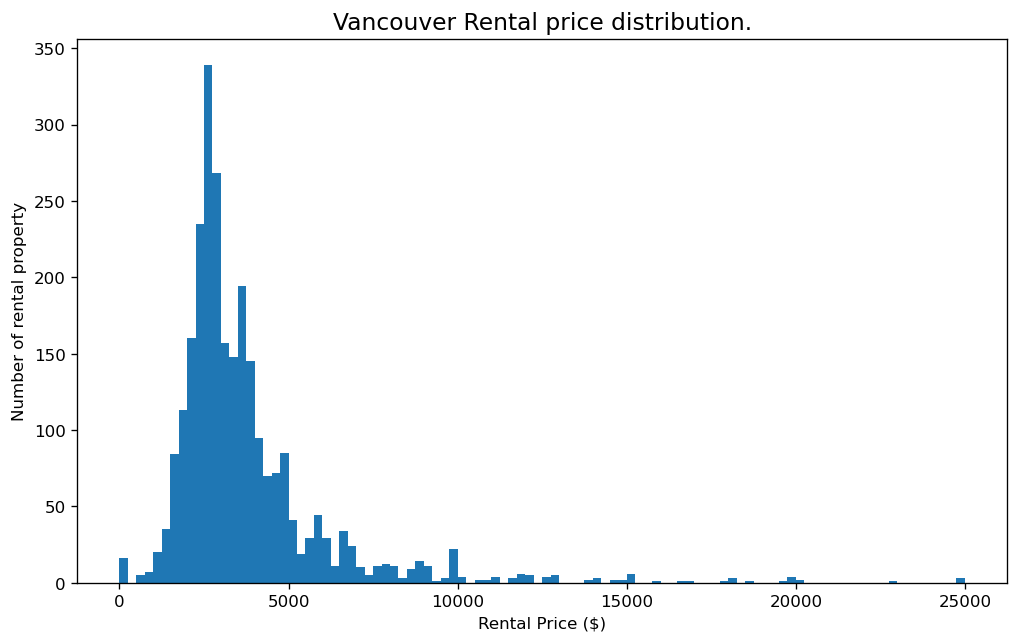

In [14]:
plt.hist(df["Price"], bins=100)
plt.title(f'{city} Rental price distribution.', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [15]:
# Search what kind of property under $300
less_than_300 = df[df["Price"].between(2, 300)]
less_than_300

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
248,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,Riley park,1,NaN,140,False
1745,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,400.0,120,True
2348,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,NaN,90,False
2652,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,650.0,100,True
2876,VANVAN,2022-11-30 20:47:00,2022-11-30,20:47:00,1 Bedroom suite furnished,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver East,1,450.0,150,True
2935,VANVAN,2022-11-29 22:17:00,2022-11-29,22:17:00,Bright Apartment to rent,https://vancouver.craigslist.org/van/apa/d/van...,Kitsilano,1,NaN,100,False


In [16]:
# One of the low price post (post around $100)
df.loc[less_than_300.index[0]]["Post URL"]

'https://vancouver.craigslist.org/van/apa/d/vancouver-new-basement-suite-in-riley/7569189658.html'

This post is daily rental. From this, I assume teh rental price around $100 would be daily rental suite. 

What about $1 or $0 posts?

In [17]:
# $1 ads
one_dollar = df[df["Price"] == 1]
one_dollar["Post URL"]

2970    https://vancouver.craigslist.org/van/apa/d/van...
Name: Post URL, dtype: object

In [18]:
# $0 ads
zero_dollar = df[df["Price"] == 0]
zero_dollar

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
452,VANVAN,2022-12-16 13:25:00,2022-12-16,13:25:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/del...,1644 NELSON ST.,0,NaN,0,False
1346,VANVAN,2022-12-14 10:31:00,2022-12-14,10:31:00,"SCAM $2,045 / 1br - 635ft2 - Suite 1 BR/Quiet ...",https://vancouver.craigslist.org/van/apa/d/van...,kits,1,NaN,0,False
1554,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,0,NaN,0,False
2176,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,Fairview,1,NaN,0,False
2434,VANVAN,2022-12-06 11:56:00,2022-12-06,11:56:00,Nice Affordable Comfy and Cozy Scams,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,0,NaN,0,False
2453,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,NaN,0,False
2995,VANVAN,2022-11-28 19:50:00,2022-11-28,19:50:00,"SCAM -$1,398 / 1br - Quiet, peaceful 1 BDRM & DEN",https://vancouver.craigslist.org/van/apa/d/van...,"4515 Langara Avenue Vancouver, BC,",0,NaN,0,False
3022,VANVAN,2022-11-28 11:18:00,2022-11-28,11:18:00,Home builder,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,6,NaN,0,False
3043,VANVAN,2022-11-27 20:45:00,2022-11-27,20:45:00,"SCAM - $1,800 - 1br 650 ft furnished short/lon...",https://vancouver.craigslist.org/van/apa/d/nor...,North Vancouver,0,NaN,0,True


I think it most likely 0 dollar and 1 dollar ads are just not showing the price, so I will drop those rows from DataFrame. 

In [19]:
# Drop low-end outliers rows
drop_index = []
for idx in one_dollar.index:
    drop_index.append(idx)
for idx in zero_dollar.index:
    drop_index.append(idx)
print(f"Original DataFrame Size:{len(df)}\nNumber of Dropped Rows: {len(drop_index)}")
df.drop(drop_index,axis=0, inplace=True)
print(f"DataFrame size after drop rows: {len(df)}")

Original DataFrame Size:2660
Number of Dropped Rows: 10
DataFrame size after drop rows: 2650


## Analyze - 1

From the Histgram, the highest amount of rental is between 1000 to 5000. First I look what kind of market above 5000. 

I call this as 

## High-End market research


In [20]:
# top 100 higest price 
top_100_price = df[['Post Datetime', 'Neighborhood', 'Bedroom', 'SQFT', 'Price', 'IsFurnished']].sort_values(
                by="Price", ascending=False).head(100)
top_100_price


,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1768,2022-12-12 10:56:00,Vancouver,4,3958.0,25000,False
1205,2022-12-14 16:51:00,Vancouver,2,2694.0,25000,True
676,2022-12-16 09:06:00,Vancouver,3,2223.0,24995,True
1395,2022-12-14 01:08:00,west vancouver,6,10000.0,22880,True
1593,2022-12-13 08:57:00,Vancouver,3,3636.0,20000,False
...,...,...,...,...,...,...
319,2022-12-16 16:51:00,city of vancouver,2,1722.0,9200,False
2401,2022-12-06 17:23:00,Vancouver,3,1750.0,9000,False
1936,2022-12-10 21:20:00,vancouver downtown,3,1516.0,9000,False
2328,2022-12-07 06:50:00,Olympic Village Vancouver,3,2454.0,9000,False


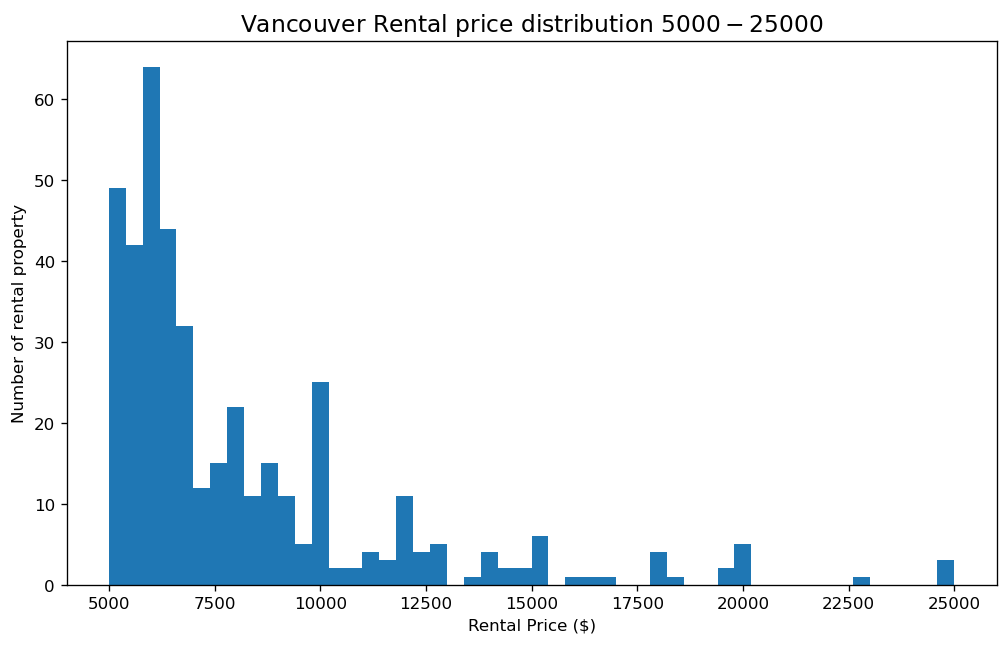

In [21]:
# What about distribution $5000 and up?
price_range = (5000, df["Price"].max())
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [22]:
# Get URL on 2 Bedroom suite in top 100. 
highest_two_bed = top_100_price[top_100_price['Bedroom'] == 2]
highest_two_bed_idx = highest_two_bed.index
for idx in highest_two_bed_idx:
    print(f'Index Number - {idx} : {df.loc[idx]["Post URL"]}')


Index Number - 1205 : https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 2251 : https://vancouver.craigslist.org/van/apa/d/vancouver-vancouver-downtown-fairmont/7554964282.html
Index Number - 2795 : https://vancouver.craigslist.org/van/apa/d/rare-harbour-green-one-ft-stunning/7563703745.html
Index Number - 2972 : https://vancouver.craigslist.org/van/apa/d/vancouver-waterfront-luxurious-bedroom/7561685356.html
Index Number - 970 : https://vancouver.craigslist.org/van/apa/d/vancouver-uniqueaccommodationscom/7567894912.html
Index Number - 844 : https://vancouver.craigslist.org/van/apa/d/vancouver-three-harbour-green-2brden-at/7568800034.html
Index Number - 2433 : https://vancouver.craigslist.org/van/apa/d/vancouver-super-luxury-07-fairmont-bed/7565383014.html
Index Number - 898 : https://vancouver.craigslist.org/van/apa/d/vancouver-luxurious-private-estates-of/7568768831.html
Index Number - 115 : https://vancouver.craigslist.org/v

#### What is 0.85% RULE?

This is the rough calculation to find out the purchase price to give 5 - 8% cash flow from your rental revenue with today's motgagerate. It's not accurate number but great place to start evaluating the home price for your investment. 

In [23]:
# Average Price on those pent house
avg_rent = np.average(highest_two_bed["Price"][1:].to_numpy())
max_rent = np.max(highest_two_bed["Price"][1:].to_numpy())
# 0.85% RULE
avg_house_p = np.round(avg_rent / (0.85/100), 2)
max_house_p = np.round(max_rent / (0.85/100), 2)
print(f"Price between ${avg_house_p*0.8} - ${max_house_p}")

Price between $1131846.544 - $2117647.06


In [24]:
# Rental price higher than $5000.
more_than_5000 = df[df["Price"] > 5000]
more_than_5000.groupby(by=["Bedroom", "IsFurnished"]).agg({'SQFT': ["min", "max"],
                                                         "Price": ['min', 'max', 'count']})

SQFT           Price             
                        min      max    min    max count
Bedroom IsFurnished                                     
0       True         1357.0   1357.0   8000   8000     1
1       False        2000.0   2000.0   6500   6500     1
        True          900.0   1855.0   5500  10000     5
2       False         675.0   2936.0   5190  18000    93
        True          800.0   2873.0   5200  25000    66
3       False          14.0   4000.0   5100  20000    80
        True         1050.0   4000.0   5200  24995    29
4       False         900.0   4600.0   5200  25000    37
        True         1450.0   6800.0   5500  18500    16
5       False        1500.0   6426.0   5200  19500    28
        True         2250.0   6500.0   6088  14995     9
6       False        2300.0  10098.0   5600  16500    12
        True         4639.0  29789.0   5600  22880     6
7       False        2900.0   4800.0   6800   9995     5
        True         6000.0   6000.0  19995  19995     1
8       False        4980.0   4980.0   7900   7900     1

In [25]:
# top 10 most expensive rental in Vancouver
top_10 = top_100_price.head(10)
top_10

,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1768,2022-12-12 10:56:00,Vancouver,4,3958.0,25000,False
1205,2022-12-14 16:51:00,Vancouver,2,2694.0,25000,True
676,2022-12-16 09:06:00,Vancouver,3,2223.0,24995,True
1395,2022-12-14 01:08:00,west vancouver,6,10000.0,22880,True
1593,2022-12-13 08:57:00,Vancouver,3,3636.0,20000,False
297,2022-12-16 17:35:00,Yaletown,3,2223.0,20000,False
509,2022-12-16 12:06:00,Dowtown,4,3700.0,19998,False
620,2022-12-16 09:35:00,West Vancouver,7,6000.0,19995,True
143,2022-12-17 09:05:00,West Vancouver,3,3600.0,19975,False
510,2022-12-16 12:06:00,Lions Bay/West Vancouver,3,3600.0,19750,False


In [26]:
# Then get the URL on those top 10 most expensive rental in Vancouver. 
top_10_idx = top_10.index
for idx in top_10_idx:
    print(f'Index Number - {idx}/Number of Bedroom - {df.loc[idx]["Bedroom"]}/SQFT - {df.loc[idx]["SQFT"]}/Location - {df.loc[idx]["Neighborhood"]}\n{df.loc[idx]["Post URL"]}')

Index Number - 1768/Number of Bedroom - 4/SQFT - 3958.0/Location - Vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-ultra-customized-morden/7567534610.html
Index Number - 1205/Number of Bedroom - 2/SQFT - 2694.0/Location - Vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 676/Number of Bedroom - 3/SQFT - 2223.0/Location - Vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-luxury-furnished-bed-den-bath/7568077632.html
Index Number - 1395/Number of Bedroom - 6/SQFT - 10000.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/west-vancouver-furnished-luxury-mansion/7562366149.html
Index Number - 1593/Number of Bedroom - 3/SQFT - 3636.0/Location - Vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-coal-harbour-luxury-three/7563551392.html
Index Number - 297/Number of Bedroom - 3/SQFT - 2223.0/Location - Yaletown
https://vancouver.craigslist.org/van/apa/d/vancouver-l

From above data, Downtown Vanvouver rental market is different world. I must make decision to define what is the outlier of high-end rental. 

If the number of the high-end prices are large enough, I can make DataFrame for only high-end and search for the high-end market opportunities. 

Clearly, I should not mix with regular market and high-end market because it will provide me biased price average to determin the valuse of the house. 

I am wondering that <a href='https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver'>CMHC Vancouver rental market report</a> concerns about those outliers. 

## Analyze - 2 


## Analyze under 5000, and i call them for regular market. 
* What is the percentage of the Furnished rental suite? 
* Is there any price different? 
* How many bedroom suite has most on ads? And is it any different in area?
* How much is the rental price in general? 


Tne price around $100 is most likely daily rental so I will store in different variable so I might be able to do something with them. 

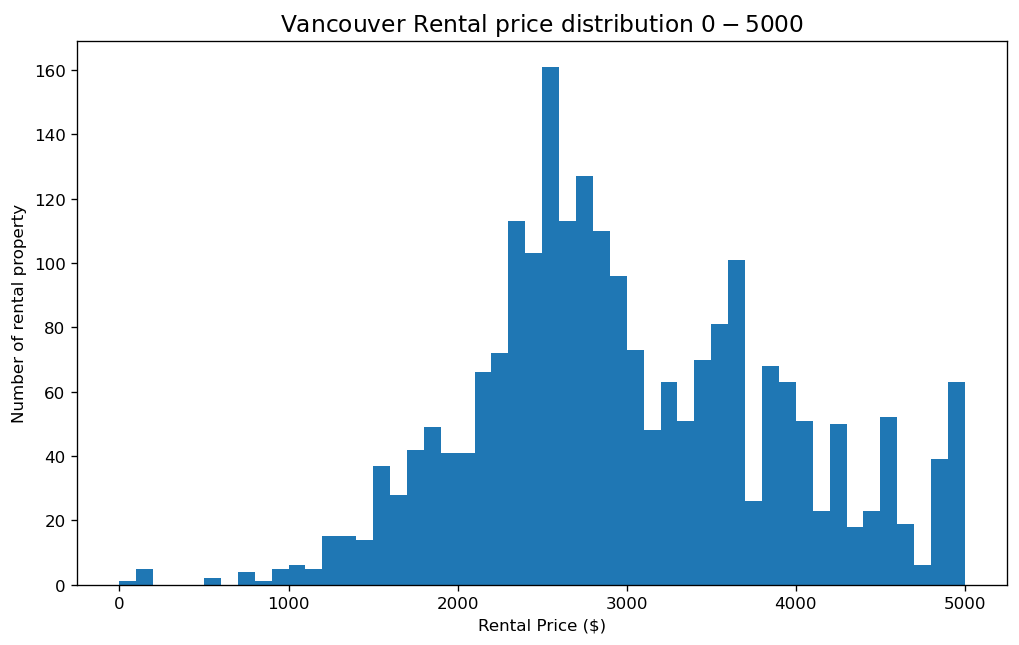

In [27]:
# What about distribution $0 - $5000?
price_range = (0, 5000)
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [28]:
day_rental = df[df["Price"].between(10, 300)]
day_rental

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
248,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,Riley park,1,NaN,140,False
1745,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,400.0,120,True
2348,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,NaN,90,False
2652,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,650.0,100,True
2876,VANVAN,2022-11-30 20:47:00,2022-11-30,20:47:00,1 Bedroom suite furnished,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver East,1,450.0,150,True
2935,VANVAN,2022-11-29 22:17:00,2022-11-29,22:17:00,Bright Apartment to rent,https://vancouver.craigslist.org/van/apa/d/van...,Kitsilano,1,NaN,100,False


In [29]:
# Drop the rental price over $5000. 
under_5000 = df.drop(more_than_5000.index, axis=0)
print(f'Drop {len(more_than_5000)} rows and data contains {len(under_5000)} rows of data.')

Drop 390 rows and data contains 2260 rows of data.


In [30]:
# then also drop daily rentals
under_5000 = under_5000.drop(day_rental.index, axis=0)
print(f'Drop {len(day_rental)} rows and data contains {len(under_5000)} rows of data.')

Drop 6 rows and data contains 2254 rows of data.


In [31]:
# What is the top 10 highest price on under $5000. Is it no outlier?
under_5000.sort_values(by="Price", ascending=False).head(10)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1103,VANVAN,2022-12-15 08:05:00,2022-12-15,08:05:00,2 Bed 2 Bath + Den/Solarium Furnished with Par...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,2,1000.0,5000,True
2836,VANVAN,2022-12-01 13:22:00,2022-12-01,13:22:00,Fully furnished Loft that sleeps 6 in Yaletown,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,1,700.0,5000,True
1441,VANVAN,2022-12-13 20:38:00,2022-12-13,20:38:00,"Fully Renovated, Entire House, Available for Rent",https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,3,2000.0,5000,False
1277,VANVAN,2022-12-14 14:00:00,2022-12-14,14:00:00,SPACIOUS WATERFRONT 2BED APARTMENT IN COAL HAR...,https://vancouver.craigslist.org/van/apa/d/van...,"Vancouver, Coal Harbour",2,1300.0,5000,False
1832,VANVAN,2022-12-11 21:20:00,2022-12-11,21:20:00,NEW BUILDING-Available February 1st -Pet Frien...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,3,745.0,5000,False
1833,VANVAN,2022-12-11 21:18:00,2022-12-11,21:18:00,Available February 1st - NEW BUILDING Pet Frie...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,3,745.0,5000,False
2986,VANVAN,2022-11-28 23:02:00,2022-11-28,23:02:00,Whole House 2 levels,https://vancouver.craigslist.org/van/apa/d/van...,Arbutus & Dunbar in Vancouver,4,2033.0,5000,False
817,VANVAN,2022-12-15 18:04:00,2022-12-15,18:04:00,(ORCA_REF#1101-1000)2 bdrm 2 bath apt,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,2,1350.0,5000,False
220,VANVAN,2022-12-16 20:31:00,2022-12-16,20:31:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,"905 E 41st AVE, Vancouver V5W 1P8",3,2000.0,5000,False
2936,VANVAN,2022-11-29 21:45:00,2022-11-29,21:45:00,(UniqueAccommodations.com) ID:5251 Furnished 2...,https://vancouver.craigslist.org/van/apa/d/van...,"Kitsilano, Vancouver",2,1280.0,5000,True


In [32]:
# How many rentals are $5000?
under_5000[under_5000["Price"] == 5000] 

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
220,VANVAN,2022-12-16 20:31:00,2022-12-16,20:31:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,"905 E 41st AVE, Vancouver V5W 1P8",3,2000.0,5000,False
291,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Furnished Short term Apartment at Avenue O...,https://vancouver.craigslist.org/van/apa/d/van...,Olympic Village,2,1000.0,5000,True
280,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Pet friendly Apartment at Cambie Gardens 7...,https://vancouver.craigslist.org/van/apa/d/van...,Oakridge,2,1155.0,5000,False
817,VANVAN,2022-12-15 18:04:00,2022-12-15,18:04:00,(ORCA_REF#1101-1000)2 bdrm 2 bath apt,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,2,1350.0,5000,False
866,VANVAN,2022-12-15 16:21:00,2022-12-15,16:21:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,Coal Harbour,2,1277.0,5000,False
899,VANVAN,2022-12-15 15:26:00,2022-12-15,15:26:00,"--(OBsold.com)-- Stunning Furnished 1bd+den, m...",https://vancouver.craigslist.org/van/apa/d/nor...,Lower Lonsdale,1,733.0,5000,True
1001,VANVAN,2022-12-15 11:35:00,2022-12-15,11:35:00,5 star luxury Shangri-La hotel condo(furnished...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,2,1045.0,5000,False
1103,VANVAN,2022-12-15 08:05:00,2022-12-15,08:05:00,2 Bed 2 Bath + Den/Solarium Furnished with Par...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,2,1000.0,5000,True
1277,VANVAN,2022-12-14 14:00:00,2022-12-14,14:00:00,SPACIOUS WATERFRONT 2BED APARTMENT IN COAL HAR...,https://vancouver.craigslist.org/van/apa/d/van...,"Vancouver, Coal Harbour",2,1300.0,5000,False
1441,VANVAN,2022-12-13 20:38:00,2022-12-13,20:38:00,"Fully Renovated, Entire House, Available for Rent",https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,3,2000.0,5000,False


In [33]:
# What is the cheapest rent?
under_5000.sort_values(by="Price").head(20)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1823,VANVAN,2022-12-11 21:39:00,2022-12-11,21:39:00,Double Car Garage for rent !!,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver East Fraserview area,0,400.0,550,False
2987,VANVAN,2022-11-28 22:57:00,2022-11-28,22:57:00,Micro-room Joyce Station,https://vancouver.craigslist.org/van/apa/d/van...,Joyce Station Vancouver,1,170.0,550,False
661,VANVAN,2022-12-16 09:08:00,2022-12-16,09:08:00,Microsuite Available Now,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,150.0,700,False
1240,VANVAN,2022-12-14 15:26:00,2022-12-14,15:26:00,Nice and cozy room available (H65) (Surrey),https://vancouver.craigslist.org/van/apa/d/sur...,Surrey,1,NaN,700,False
226,VANVAN,2022-12-16 19:59:00,2022-12-16,19:59:00,Unique Basement Suite with High Ceiling,https://vancouver.craigslist.org/van/apa/d/van...,East first ave Vancouver BC,1,150.0,700,False
2730,VANVAN,2022-12-03 08:11:00,2022-12-03,08:11:00,1 bedroom available for rent in a shared suite,https://vancouver.craigslist.org/van/apa/d/van...,21st east avenue and Maxwell,1,650.0,750,False
2340,VANVAN,2022-12-06 23:42:00,2022-12-06,23:42:00,Room for rent $830/month! utilities & internet...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,997.0,830,False
519,VANVAN,2022-12-16 11:50:00,2022-12-16,11:50:00,student accommodation,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,800.0,900,False
2629,VANVAN,2022-12-04 20:40:00,2022-12-04,20:40:00,One in Kits on West Broadway 10 mins from UBC...,https://vancouver.craigslist.org/van/apa/d/van...,"Kitsilano, Vancouver",6,NaN,950,False
835,VANVAN,2022-12-15 17:43:00,2022-12-15,17:43:00,"1 bedroom in a new house, near PNE, for rent",https://vancouver.craigslist.org/van/apa/d/van...,"East Vancouver, Renfrew and Hastings",1,110.0,950,False


In [34]:
# Count how many rentals are furnished 
num_furnished_suite = df[df['IsFurnished'] == True]["IsFurnished"].count()
num_unfurnished_suite = len(df) - num_furnished_suite
furnished_suite_percent = np.round((num_furnished_suite / len(df)) * 100, 2)
print(f"Number of furnished suite is {num_furnished_suite}, and it's {furnished_suite_percent}% of the entire list.")

Number of furnished suite is 633, and it's 23.89% of the entire list.


In [35]:
# Find out the number of ads on each bedrooms number.  
num_bed = np.sort(df["Bedroom"].unique())
suite_counts = []
for i in range(len(num_bed)):
    suite_count = len(df[df['Bedroom'] == num_bed[i]])
    suite_counts.append(suite_count)
    #print(f'Number of {num_bed[i]} Bedroom suite: {len(df[df["Bedroom"] == num_bed[i]])}')
#print(f"List of suite counts: {suite_counts}")

In [36]:
# Find out Mean, Max, Min of SQFT and Price of each bedroom and SUM of furnished suite and total suite on each bedroom. 
df_count = df.groupby(by=['Bedroom']).agg({'SQFT': ['mean', 'max', 'min'],
                                                 'Price': ['mean', 'max', 'min'],
                                                  'IsFurnished': ['sum', 'count']})
df_count['percent furnished'] = df_count['IsFurnished']['sum'] / df_count["IsFurnished"]['count']
df_count

SQFT                         Price              IsFurnished  \
                mean      max     min         mean    max   min         sum   
Bedroom                                                                       
0         435.916667   1357.0   103.0  2260.511905   8000   550          49   
1         621.217281   2400.0     1.0  2550.808840  10000    90         253   
2         988.018756   2936.0   500.0  3928.289167  25000  1000         248   
3        1556.848921   4000.0    14.0  5478.940199  24995  1000          50   
4        2674.064935   6800.0   900.0  6903.406977  25000   950          17   
5        3700.390244   6500.0  1500.0  8416.711111  19500  1300           9   
6        6842.166667  29789.0  2300.0  9565.250000  22880   950           6   
7        4028.333333   6000.0  1300.0  9084.285714  19995  1300           1   
8        4980.000000   4980.0  4980.0  7900.000000   7900  7900           0   

              percent furnished  
        count                    
Bedroom                          
0         168          0.291667  
1         905          0.279558  
2        1117          0.222023  
3         301          0.166113  
4          86          0.197674  
5          45          0.200000  
6          20          0.300000  
7           7          0.142857  
8           1          0.000000

In [37]:
# Price per furnished suit on each bedroom
#df_price_furnished = df.drop(['Post Datetime', 'Post Title', 'Post URL', 'Neighborhood'], axis=1)
df_price_furnished = df.groupby(['Bedroom', 'IsFurnished']).agg({'Price': ['mean', 'max', 'min', 'count'],
                                                               "SQFT": ['mean', 'max', 'min']})
df_price_furnished

Price                              SQFT           \
                             mean    max    min count          mean      max   
Bedroom IsFurnished                                                            
0       False         2195.731092   4050    550   119    436.611650   1200.0   
        True          2417.836735   8000   1000    49    434.170732   1357.0   
1       False         2402.110429   6500     90   652    623.026978   2400.0   
        True          2934.015810  10000    100   253    616.861472   1855.0   
2       False         3723.090909  18000   1000   869    970.916986   2936.0   
        True          4647.310484  25000   1175   248   1046.239130   2873.0   
3       False         5125.063745  20000   1000   251   1528.855895   4000.0   
        True          7255.400000  24995   2500    50   1687.673469   4000.0   
4       False         6334.173913  25000    950    69   2607.377049   4600.0   
        True          9213.823529  18500   4800    17   2928.312500   6800.0   
5       False         8168.861111  19500   1300    36   3706.062500   6426.0   
        True          9408.111111  14995   6088     9   3680.222222   6500.0   
6       False         8416.071429  16500    950    14   5079.307692  10098.0   
        True         12246.666667  22880   5600     6  11425.600000  29789.0   
7       False         7265.833333   9995   1300     6   3634.000000   4800.0   
        True         19995.000000  19995  19995     1   6000.000000   6000.0   
8       False         7900.000000   7900   7900     1   4980.000000   4980.0   

                             
                        min  
Bedroom IsFurnished          
0       False         103.0  
        True          180.0  
1       False           1.0  
        True          361.0  
2       False         500.0  
        True          500.0  
3       False          14.0  
        True          781.0  
4       False         900.0  
        True         1450.0  
5       False        1500.0  
        True         2250.0  
6       False        2300.0  
        True         4639.0  
7       False        1300.0  
        True         6000.0  
8       False        4980.0

Dropped extrimely low price add, and it seems no outlier on the price

In [38]:
# Count how many ads per day.1=Mon, 2=Tue, ......, 7=Sun
df["Weekday"] = df["Post Datetime"].dt.isocalendar().day
num_ad_per_day_df = df.groupby('Post Date').agg({'Post Title': 'count',
                                                "Weekday": 'first'})

num_ad_per_day_df

,Post Title,Weekday
Post Date,,
2022-11-27,16,7
2022-11-28,39,1
2022-11-29,44,2
2022-11-30,50,3
2022-12-01,65,4
2022-12-02,51,5
2022-12-03,43,6
2022-12-04,59,7
2022-12-05,122,1


Which day of the week have more ads? 

Is there any day of the week that having more ads than others? 

## Share

#### Data Visualization:
The most important thing is what information do I want to tell. 

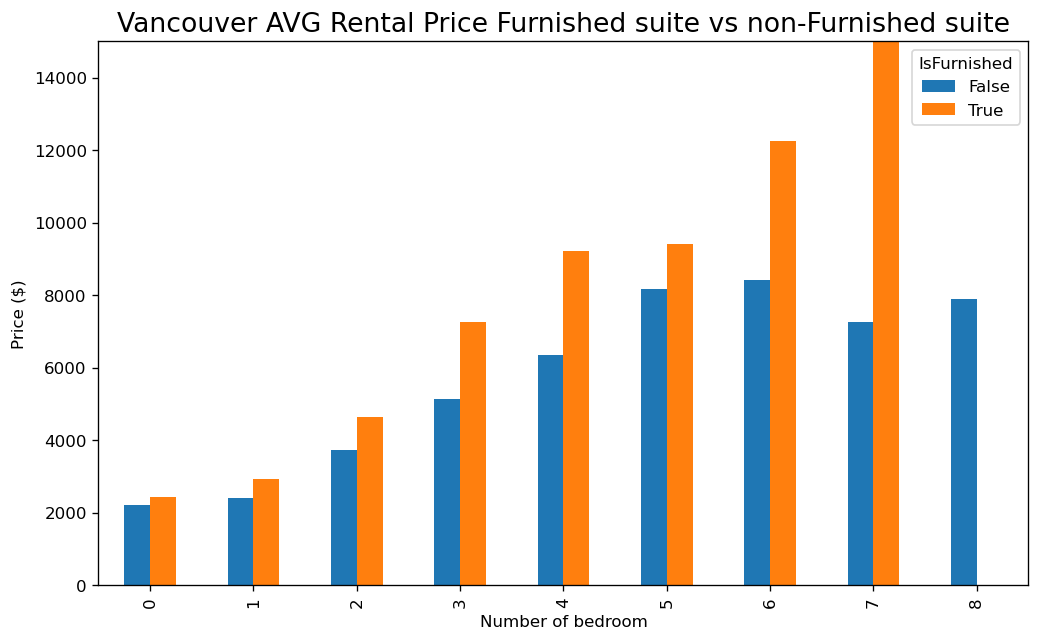

In [44]:
df_price_furnished["Price"]["mean"].unstack().plot(kind='bar')
plt.title(f'{city} AVG Rental Price Furnished suite vs non-Furnished suite', fontsize=16)
plt.xlabel('Number of bedroom')
plt.ylabel('Price ($)')
plt.ylim((0, 15000));

## Act